# Time Series Analysis of Geomagnetic Storms

In [1]:
#importing required libraries

import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import statsmodels.api as sm
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

In [2]:
ss= pd.read_csv('events.csv')

ss.rename(columns={"Year":"year"}, inplace=True)
year=ss['year']
all_storm=ss['all-storm']
mod_storm=ss['mod-storm']
intense_storm=ss['intense-storm']
super_storm=ss['super-storm']



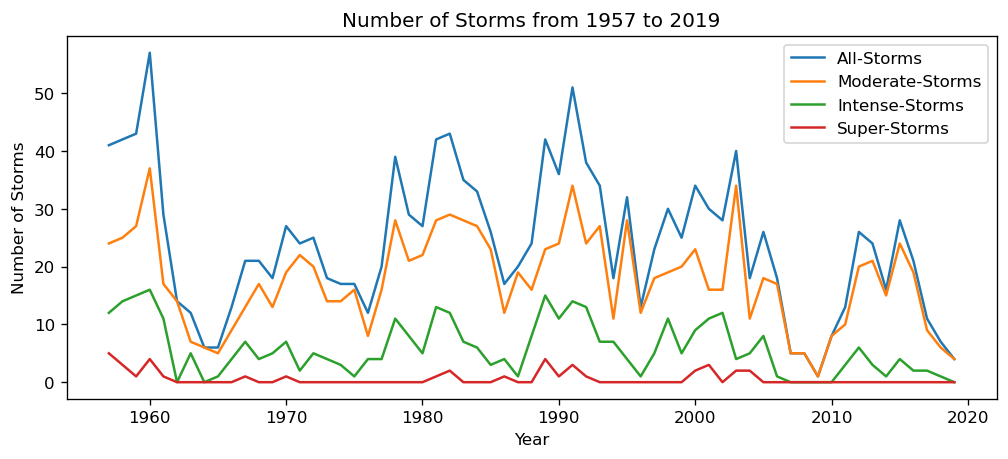

In [3]:
plt.figure(figsize=(10,4))
plt.plot(year,all_storm,label='All-Storms')
plt.plot(year,mod_storm,label='Moderate-Storms')
plt.plot(year,intense_storm,label='Intense-Storms')
plt.plot(year,super_storm,label='Super-Storms')
plt.xlabel('Year')
plt.ylabel('Number of Storms')
plt.title('Number of Storms from 1957 to 2019')
plt.legend()
plt.show()

#### Augumented Dickey-Fuller Test is performed to determine whether the time series is stationary or not.

In [4]:
from statsmodels.tsa.stattools import adfuller

X = all_storm.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.332923
p-value: 0.013469
Critical Values:
	1%: -3.541
	5%: -2.909
	10%: -2.592


Based on these values, we can say that the series is non-stationary because the ADF Statistic is greater than 1% values of the time series. We need to difference the series to make it stationary.

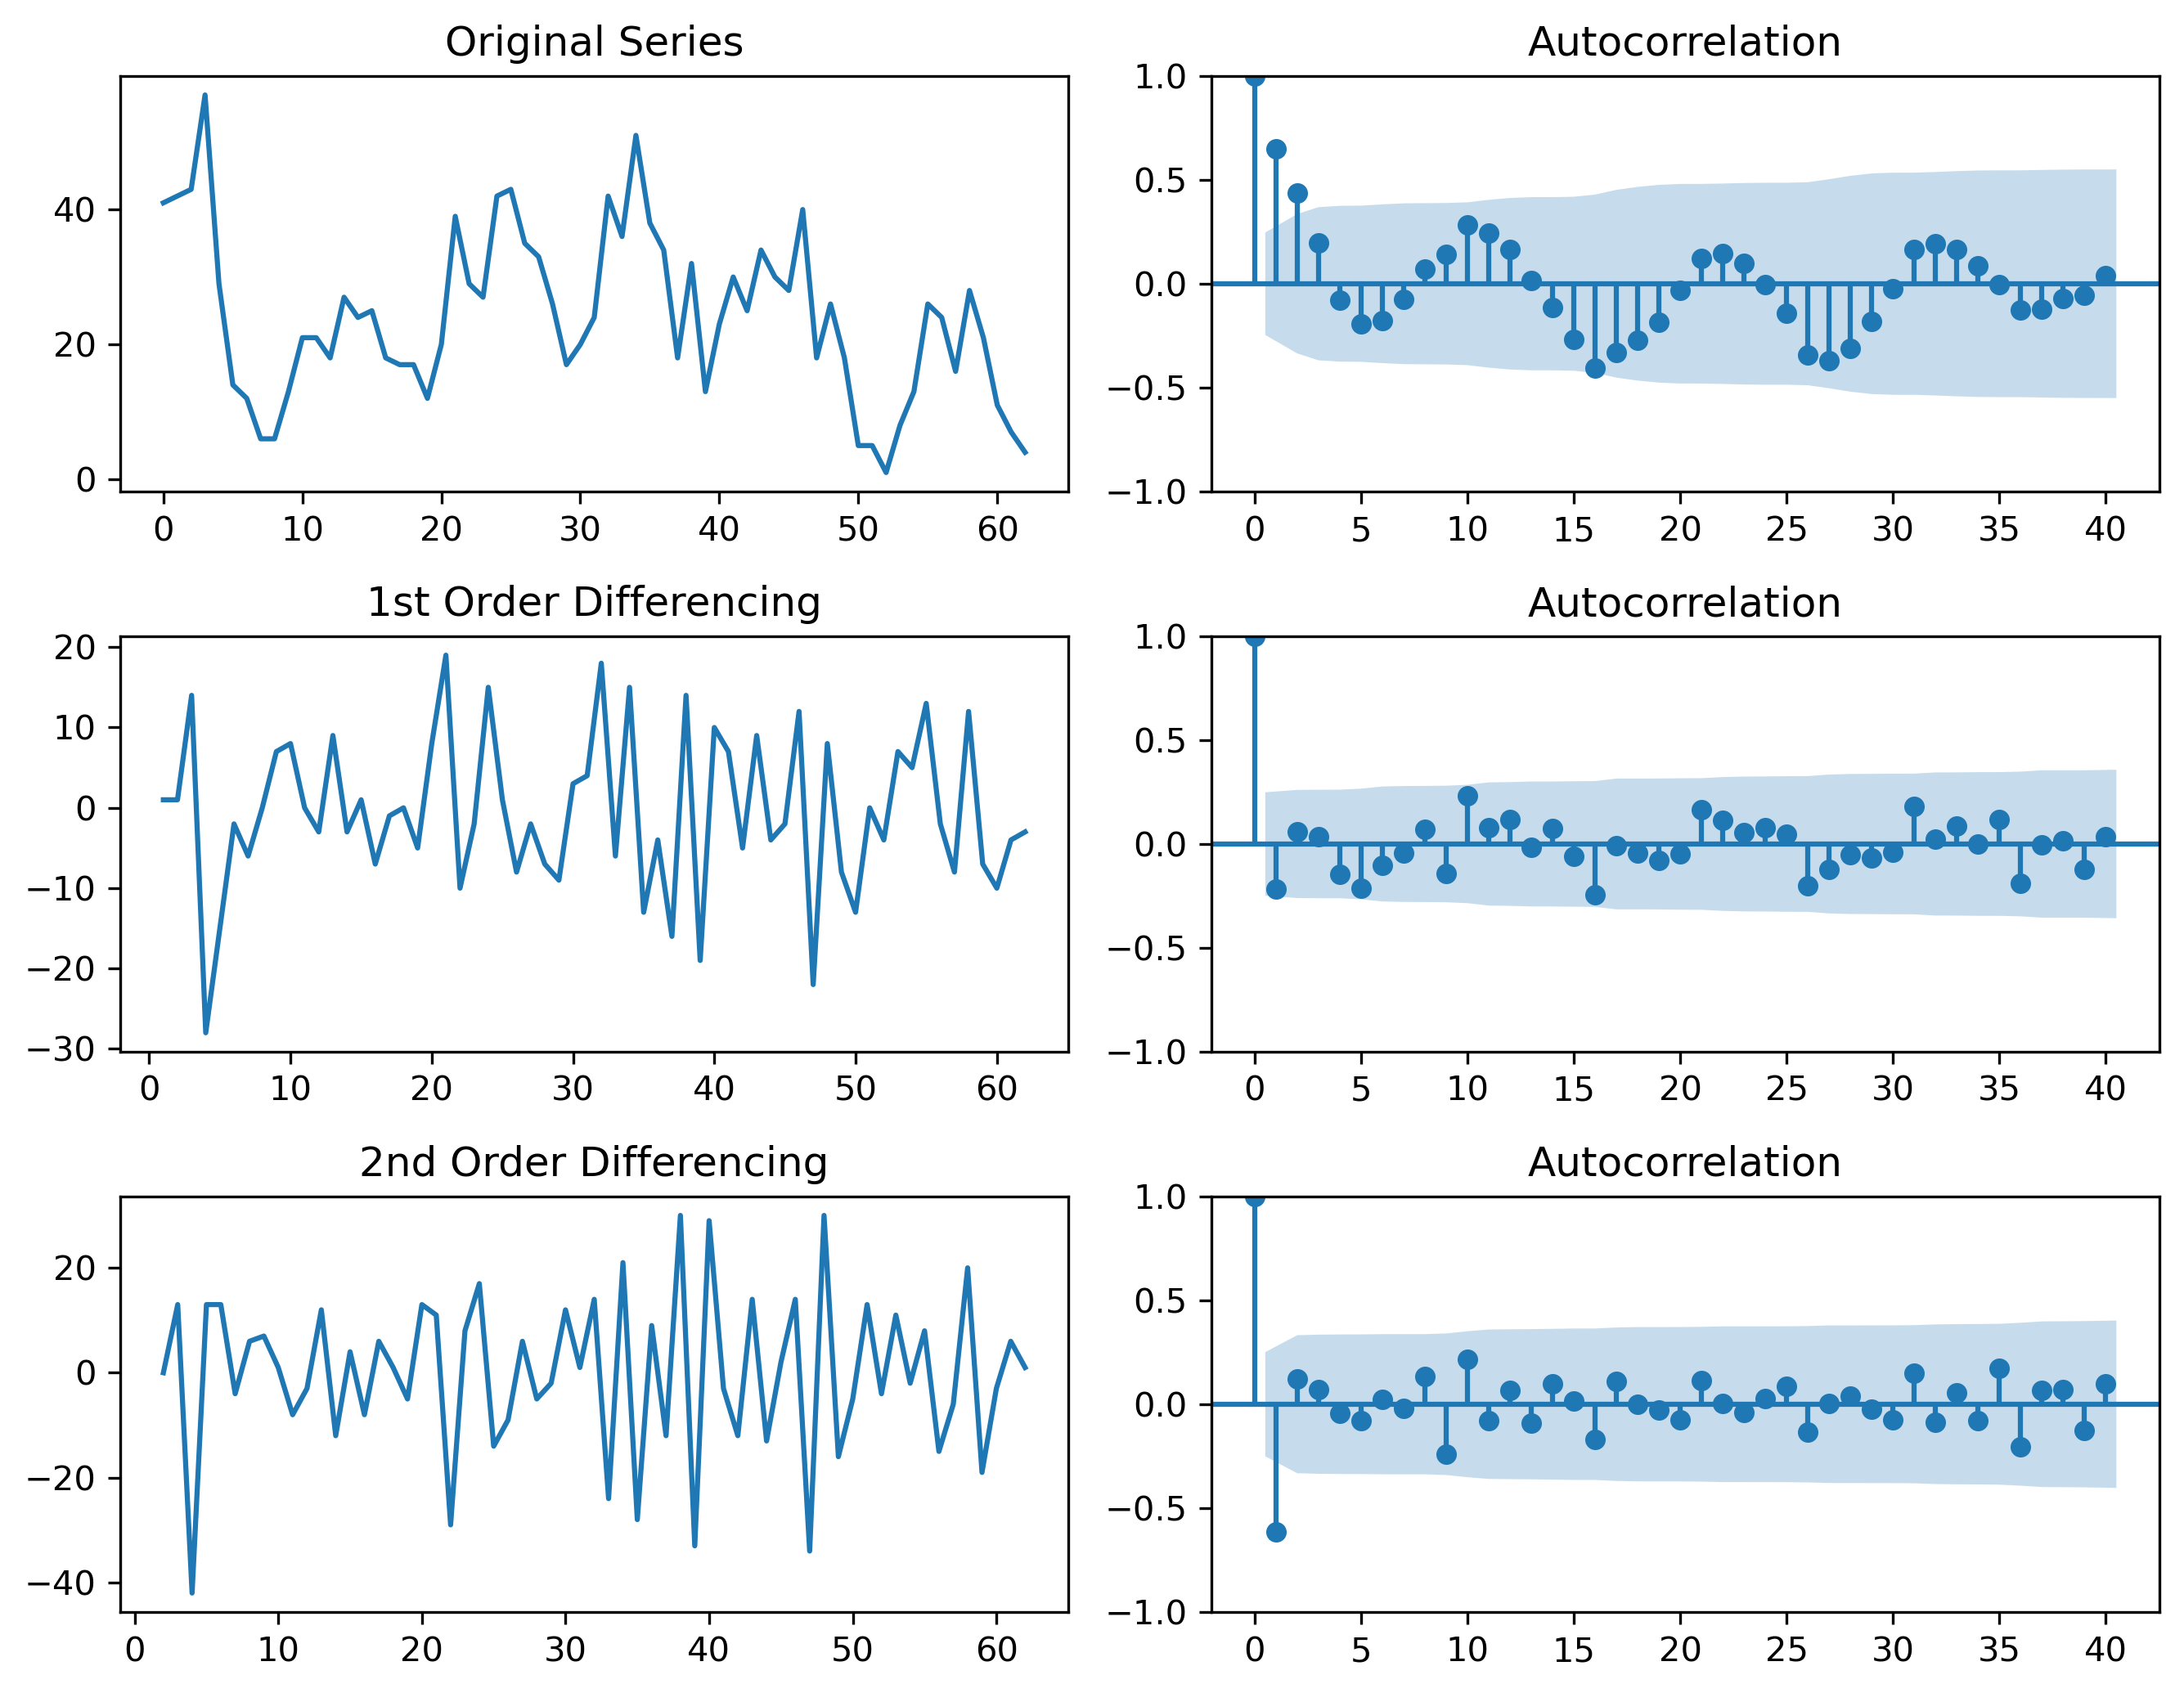

In [5]:
#manually finding the best fit for p,d,q values

all_storm_diff=all_storm.diff()


# Original Series
fig, axes = plt.subplots(3, 2,dpi=300)
axes[0, 0].plot(all_storm); axes[0, 0].set_title('Original Series')
plot_acf(all_storm, ax=axes[0, 1],lags=40)

# 1st Differencing
axes[1, 0].plot(all_storm.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(all_storm.diff().dropna(), ax=axes[1, 1],lags=40)

# 2nd Differencing
axes[2, 0].plot(all_storm.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(all_storm.diff().diff().dropna(), ax=axes[2, 1],lags=40)
plt.tight_layout()
plt.show()

#As there are significant values out of the blue region in both 1st and 2nd order differencing tentatively d value is fixed at '0'

In [6]:
from statsmodels.tsa.stattools import adfuller

X = all_storm_diff.dropna().values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.473422
p-value: 0.000220
Critical Values:
	1%: -3.560
	5%: -2.918
	10%: -2.597


D:\Astro-Pro\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


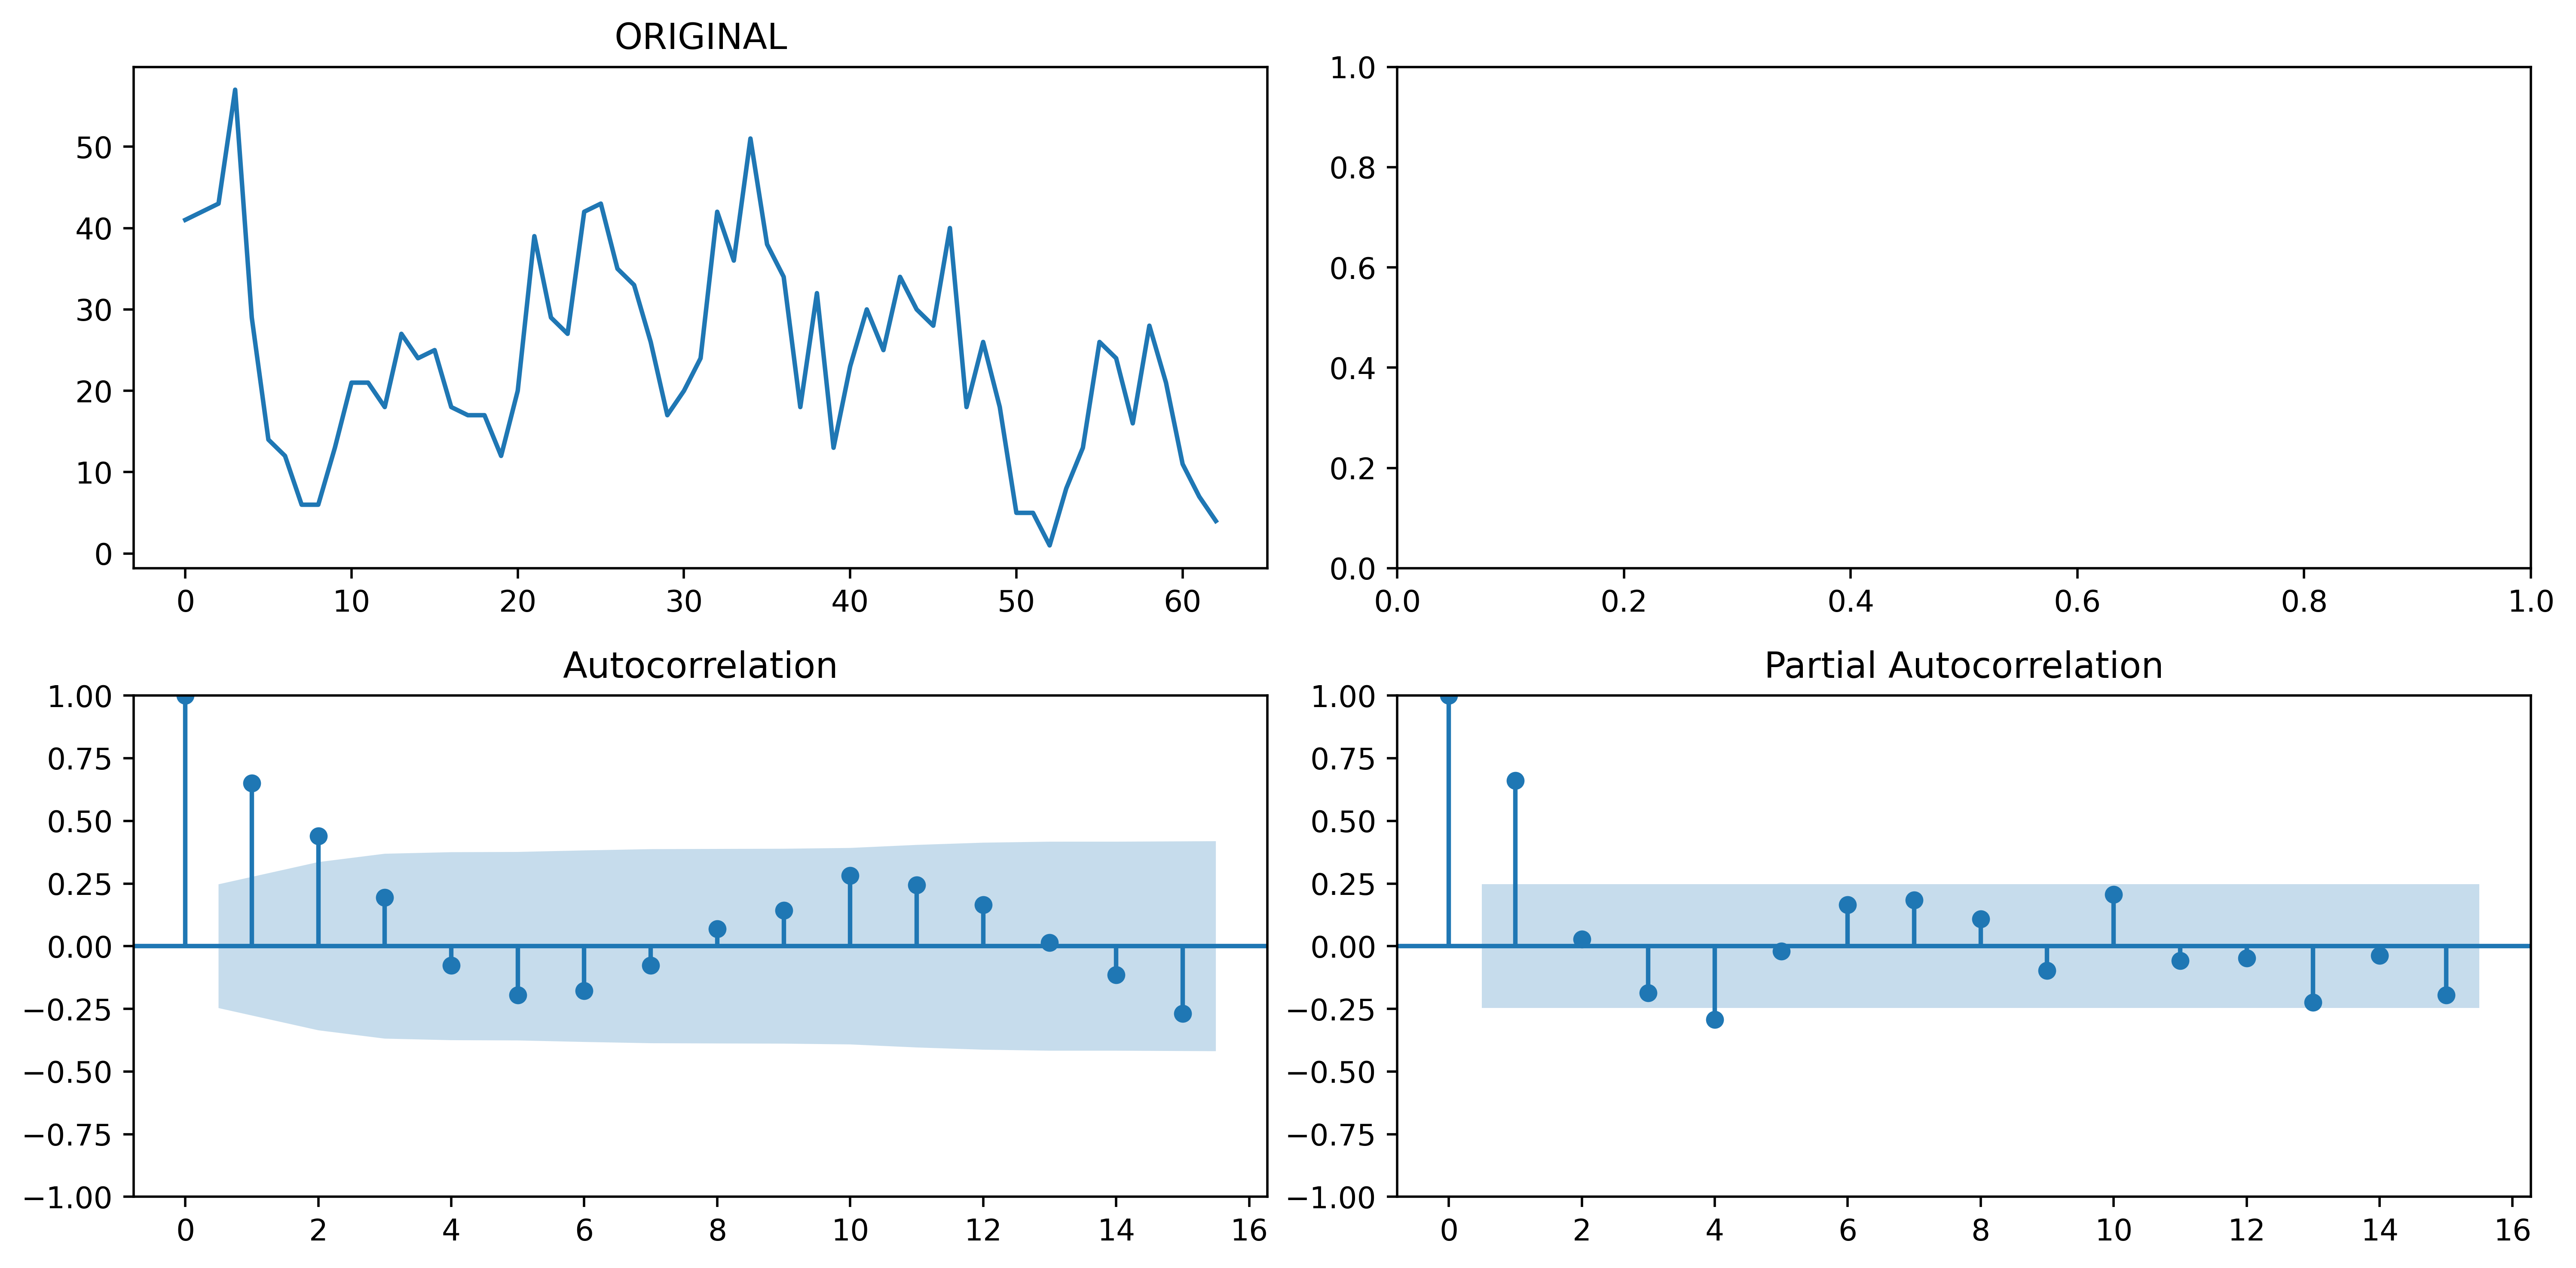

In [7]:
plt.rcParams.update({'figure.figsize':(12,6), 'figure.dpi':120})

fig, axes = plt.subplots(2, 2, dpi=500)
axes[0,0].plot(all_storm); axes[0,0].set_title('ORIGINAL')

plot_acf(all_storm.dropna(), ax=axes[1,0],lags=15)
plot_pacf(all_storm.dropna(), ax=axes[1,1],lags=15)
plt.tight_layout()
plt.show()

For this set, the corresponding p,d,q values are 0,1,1 which are decided based on the spikes in plots

D:\Astro-Pro\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


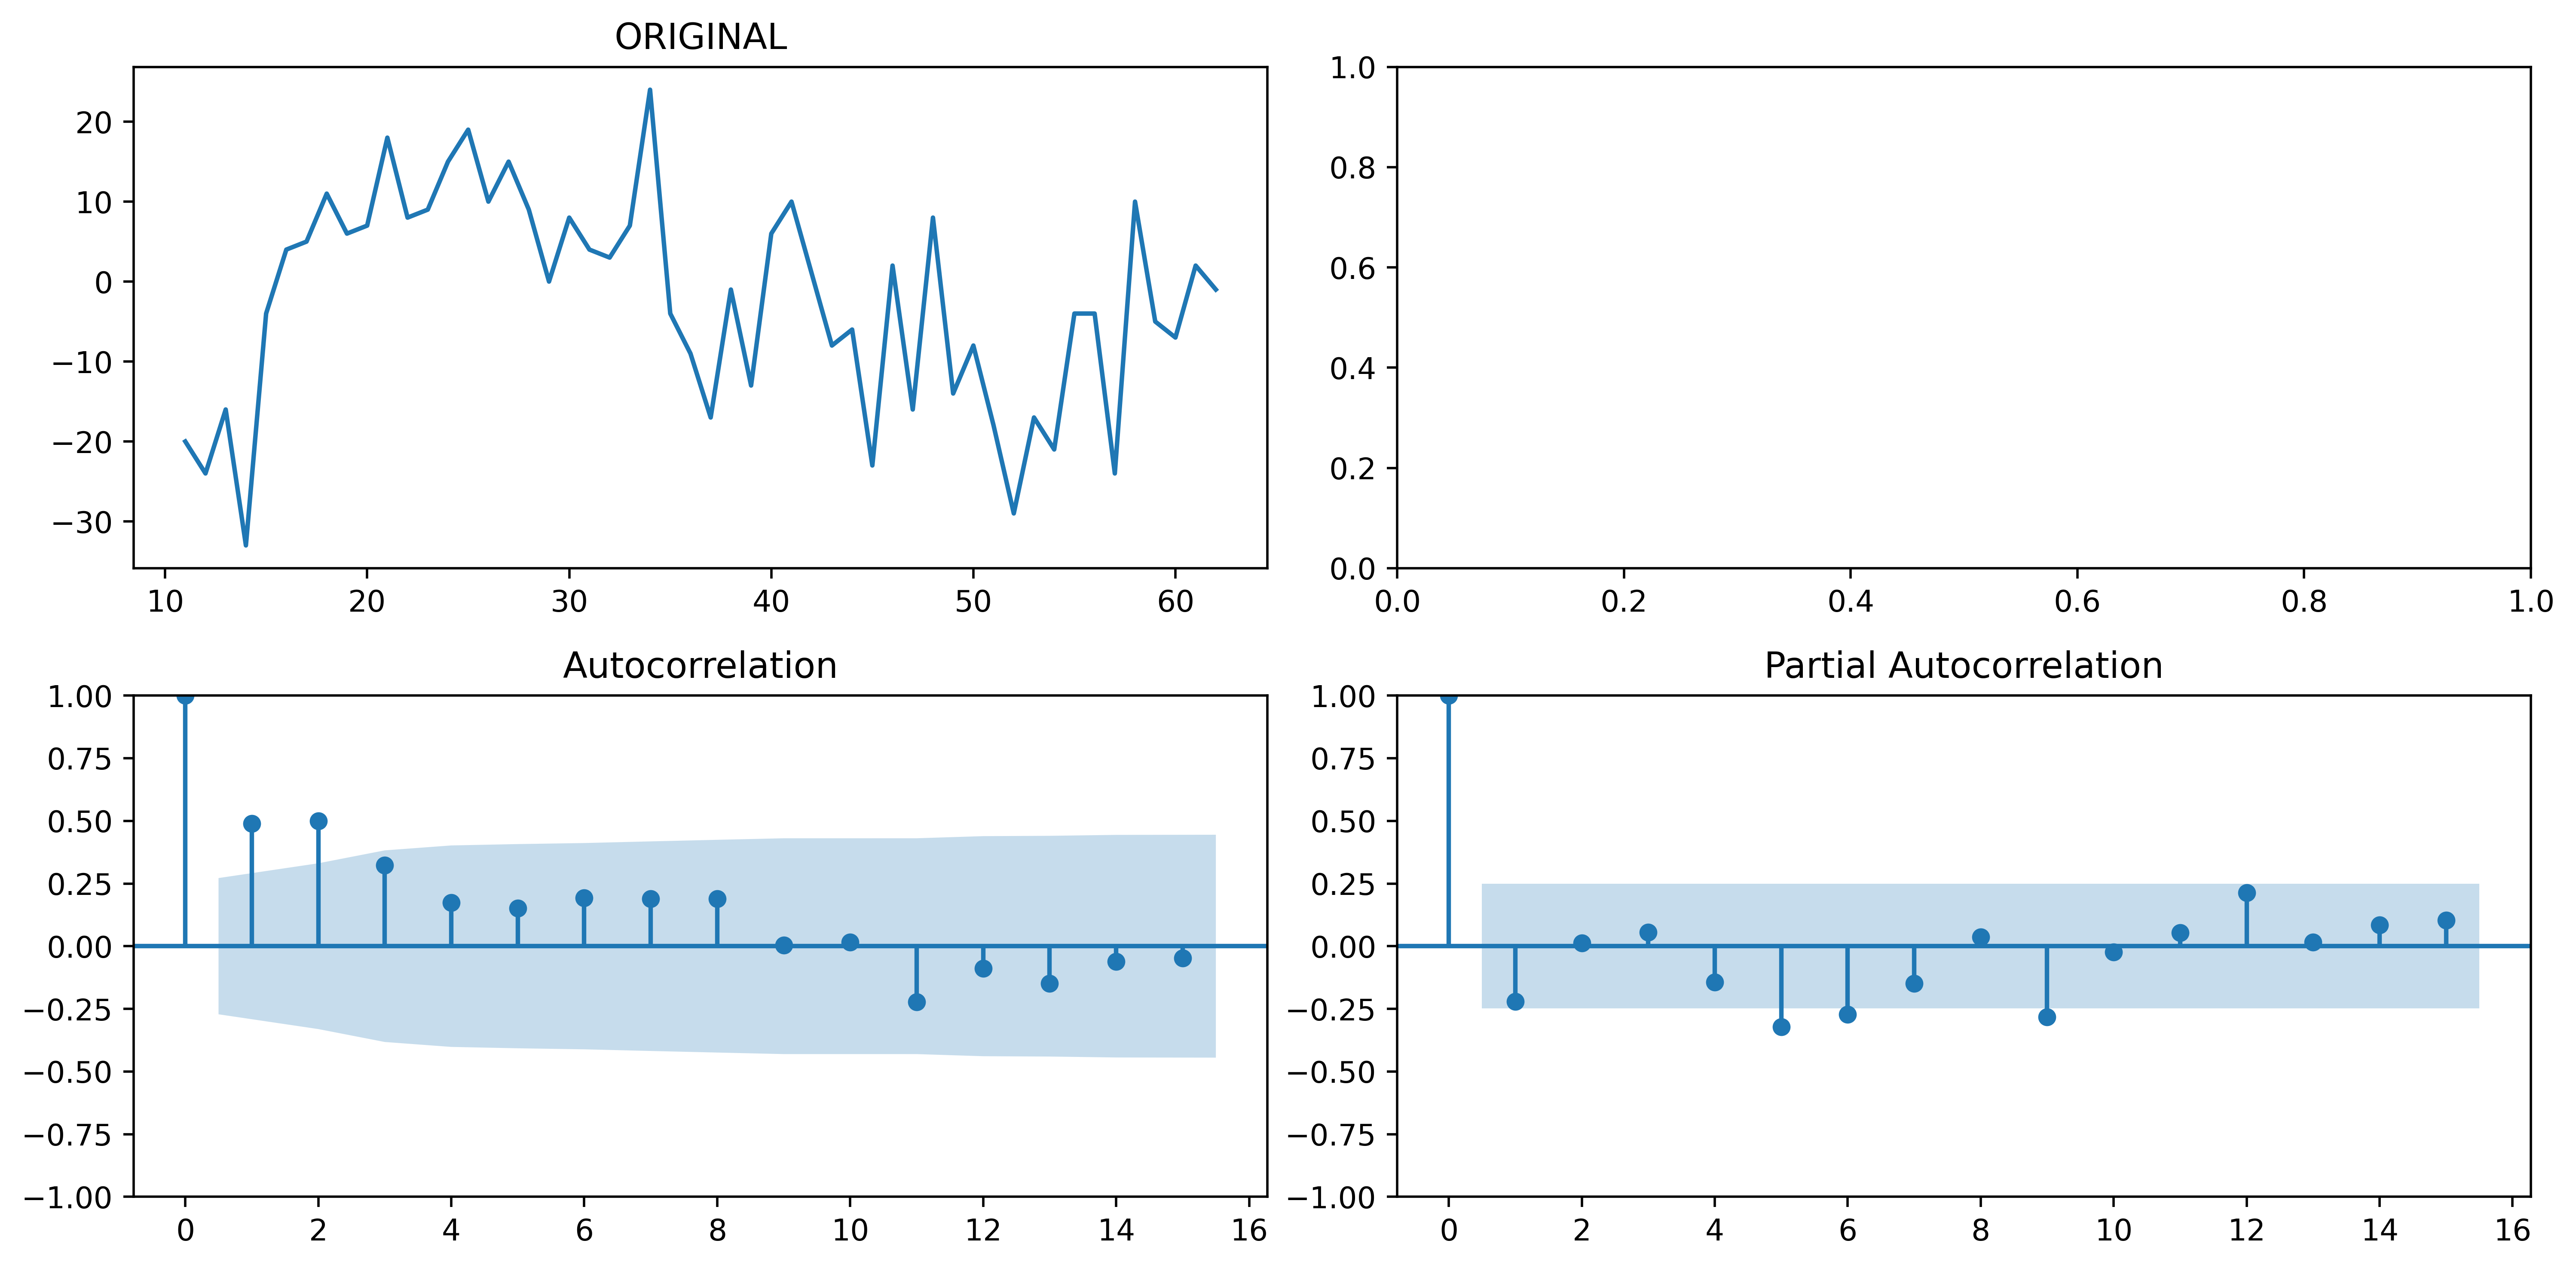

In [8]:
plt.rcParams.update({'figure.figsize':(12,6), 'figure.dpi':120})

fig, axes = plt.subplots(2, 2, dpi=500)
axes[0,0].plot(all_storm.diff(11)); axes[0,0].set_title('ORIGINAL')

plot_acf(all_storm.diff(11).dropna(), ax=axes[1,0],lags=15)
plot_pacf(all_storm.diff().dropna(), ax=axes[1,1],lags=15)
plt.tight_layout()
plt.show()

For this set, the corresponding p,d,q values are 0,1,1 which are decided based on the spikes in plots

In [9]:
#running a function to find the best model with the least AIC value


import itertools

def sarima_grid_search(y,seasonal_period):
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2],seasonal_period) for x in list(itertools.product(p, d, q))]
    
    mini = float('+inf')
    
    
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(y,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                results = mod.fit()
                
                if results.aic < mini:
                    mini = results.aic
                    param_mini = param
                    param_seasonal_mini = param_seasonal

#                 print('SARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            except:
                continue
    print('The set of parameters with the minimum AIC is: SARIMA{}x{} - AIC:{}'.format(param_mini, param_seasonal_mini, mini))

In [10]:
sarima_grid_search(all_storm,11)

The set of parameters with the minimum AIC is: SARIMA(0, 1, 1)x(0, 1, 1, 11) - AIC:277.9290561508185


In [11]:
#Model fitting with optimum p,d,q values


from statsmodels.tsa.statespace.sarimax import SARIMAX

#10,0,1 ARIMA Model
model = SARIMAX(all_storm, order=(0,1,1), seasonal_order=(0,1,1,11), enforce_stationarity=False, enforce_invertibility=False)
model_fit = model.fit()
print(model_fit.summary())


                                     SARIMAX Results                                      
Dep. Variable:                          all-storm   No. Observations:                   63
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 11)   Log Likelihood                -135.965
Date:                            Mon, 19 Sep 2022   AIC                            277.929
Time:                                    00:31:13   BIC                            282.842
Sample:                                         0   HQIC                           279.677
                                             - 63                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6926      0.121     -5.730      0.000      -0.930      -0.456
ma.S.L11      -1.0000   2563.433   

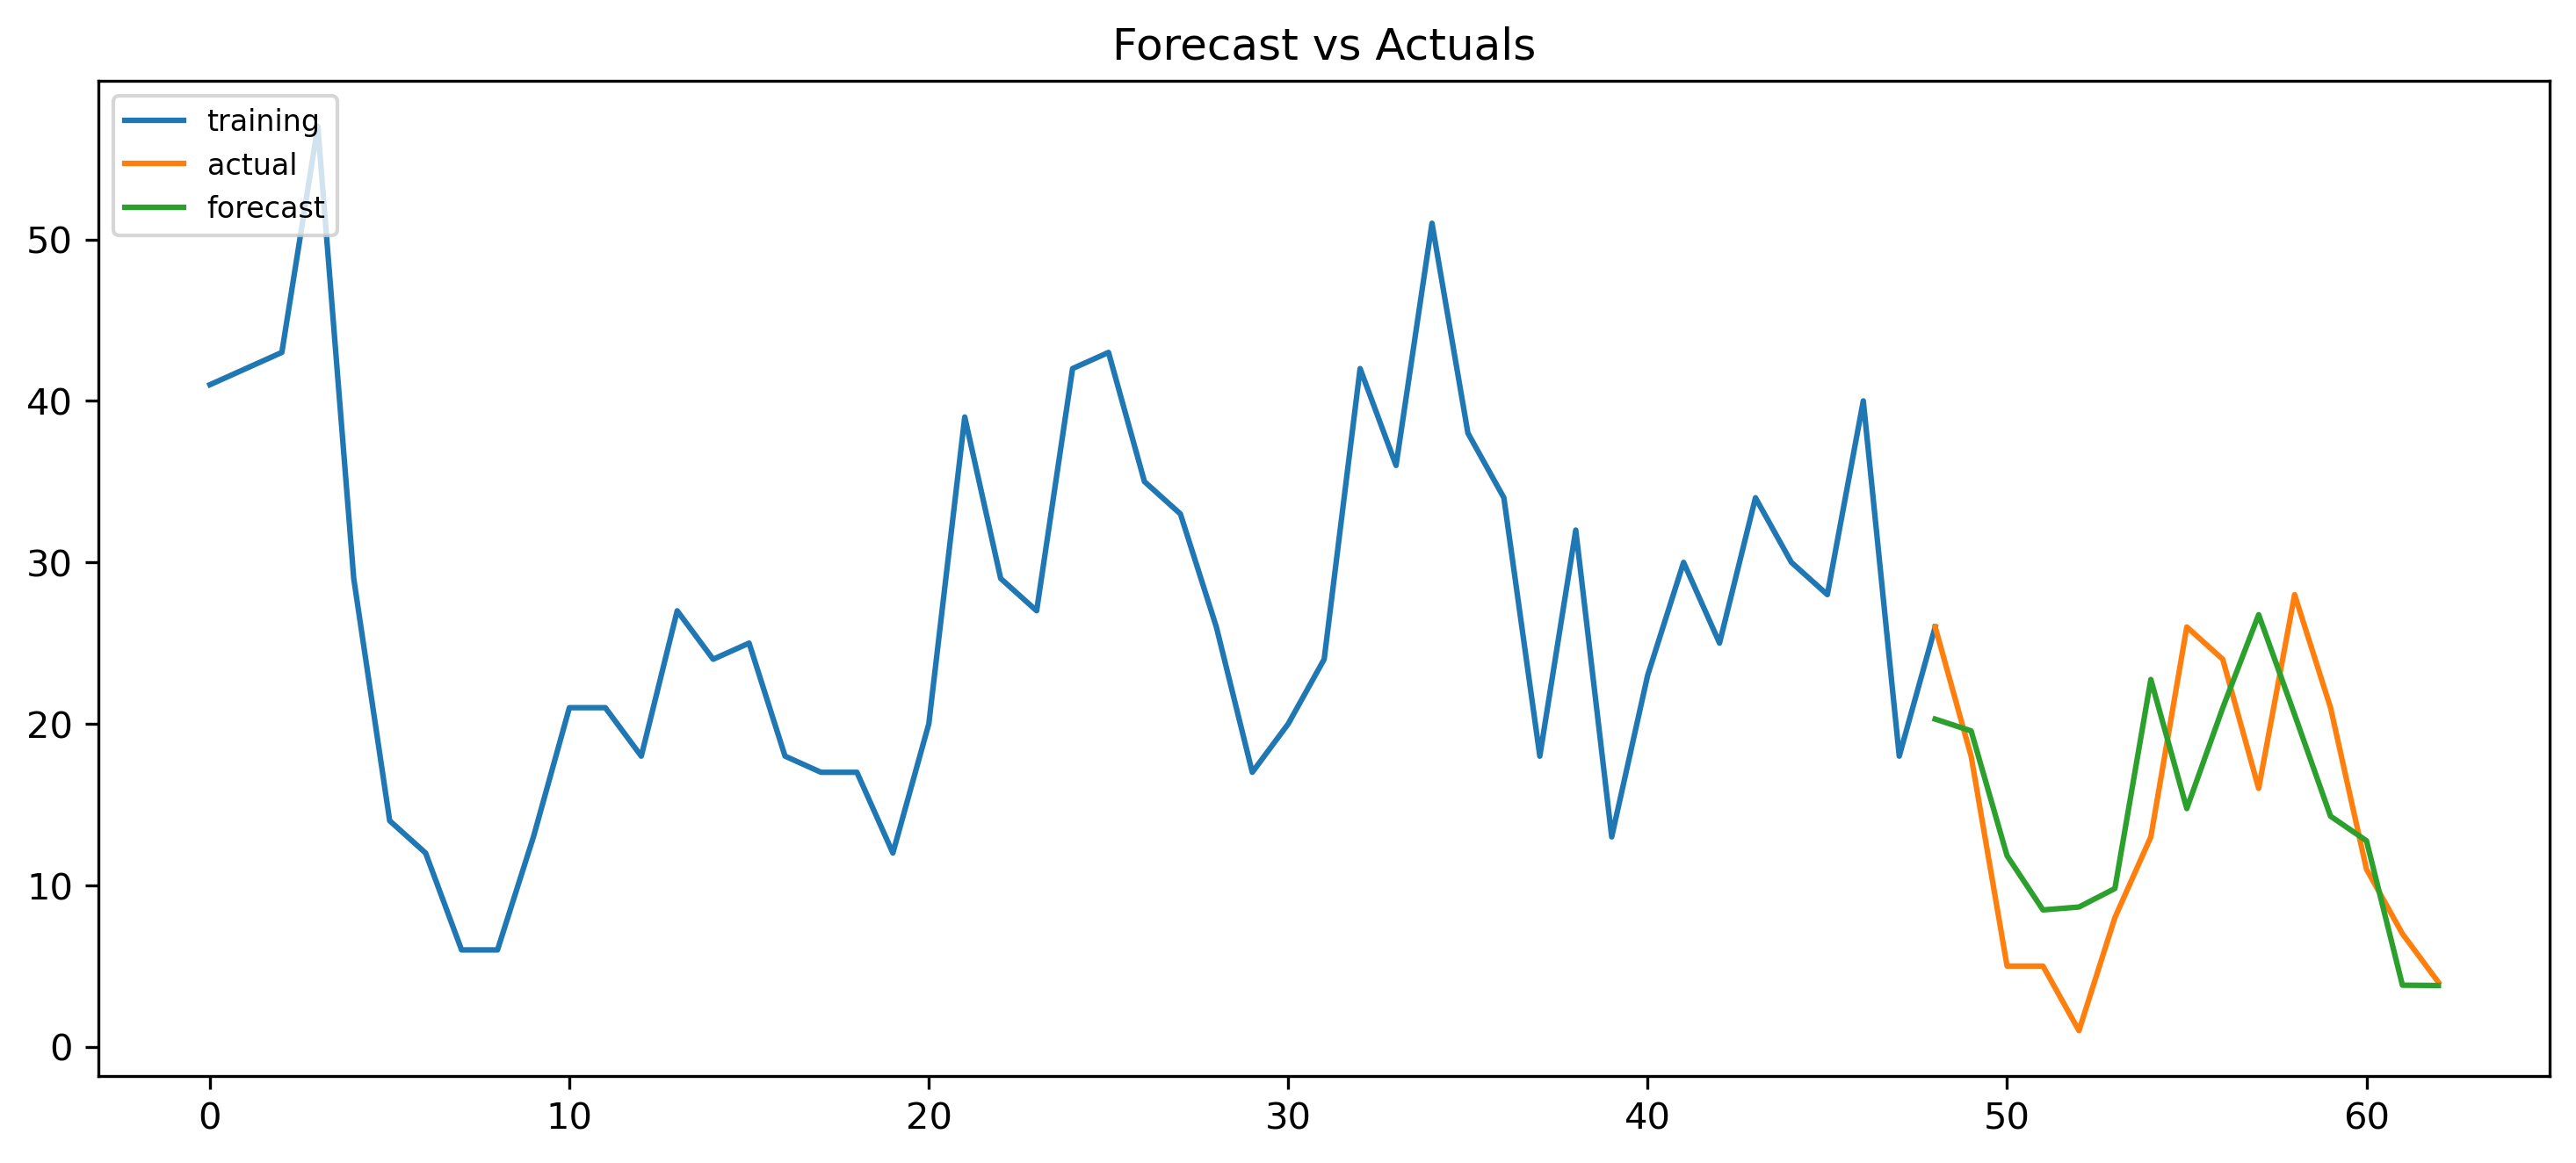

In [12]:
#training and testing data

all_storm_train=all_storm[:49]
test=all_storm[48:]
model = SARIMAX(all_storm, order=(0,1,1), seasonal_order=(0,1,1,11), enforce_stationarity=False, enforce_invertibility=False)  
fitted = model.fit()  

# Forecast
fc = fitted.predict(start=48)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
# lower_series = pd.Series(fc[:, 0], index=test.index)
# upper_series = pd.Series(fc[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=300)
plt.plot(all_storm_train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
# plt.fill_between(lower_series.index, lower_series, upper_series, 
#                  color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
# plt.xlim(200,330)
plt.show()


In [13]:
from statsmodels.tsa.stattools import acf

def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(fc, test)

C:\Users\Santhosh Pamula\AppData\Local\Temp\ipykernel_19664\3769355770.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mins = np.amin(np.hstack([forecast[:,None],
C:\Users\Santhosh Pamula\AppData\Local\Temp\ipykernel_19664\3769355770.py:11: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)
C:\Users\Santhosh Pamula\AppData\Local\Temp\ipykernel_19664\3769355770.py:12: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  maxs = np.amax(np.hstack([forecast[:,None],
C:\Users\Santhosh Pamula\AppData\Local\Temp\ipykernel_19664\3769355770.py:13: FutureWarning: Support

{'mape': 0.8987829515719941,
 'me': 0.4063397398136162,
 'mae': 5.406380654197209,
 'mpe': 0.649634618281746,
 'rmse': 6.40603280988061,
 'acf1': -0.12472457809792524,
 'corr': 0.6959581017433125,
 'minmax': 0.33152132618333296}

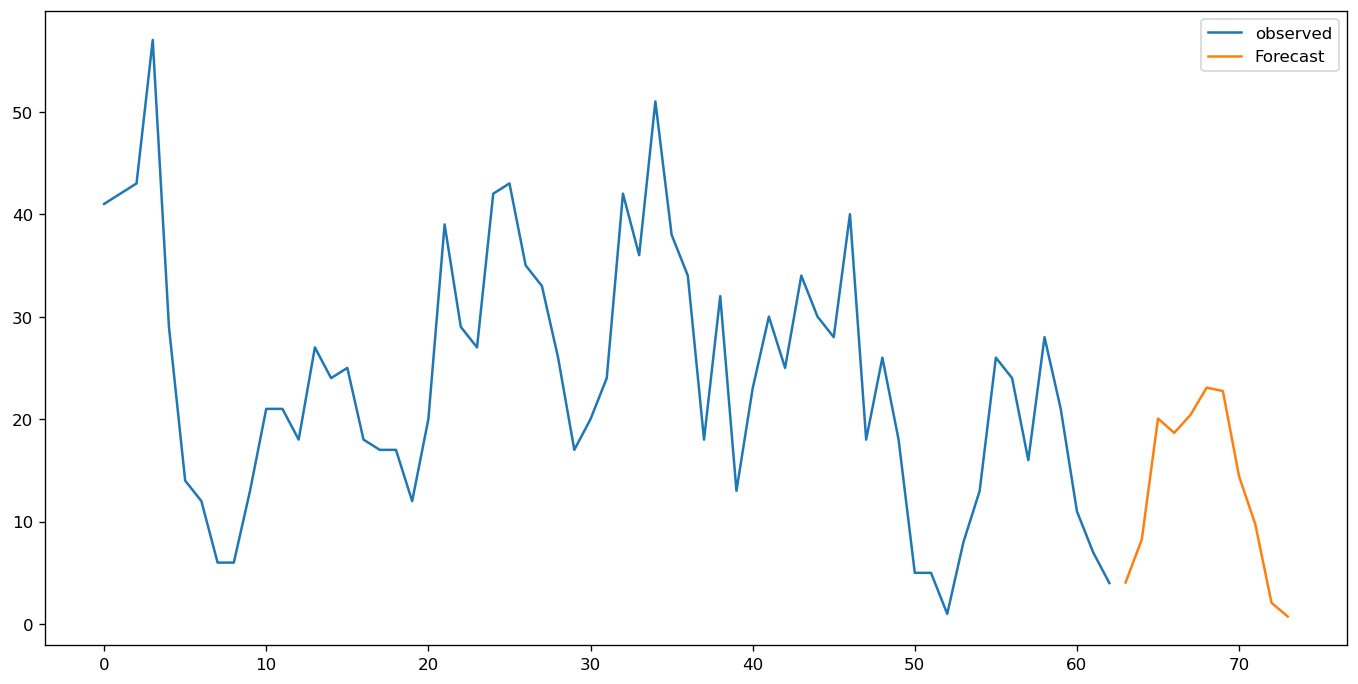

In [14]:
# forecasting data based on the previous data predictions

pred_uc=fitted.get_forecast(steps=11)
ax = all_storm.plot(label='observed', figsize=(14, 7))
#     print(pred_uc.predicted_mean)
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
plt.legend()
plt.show()

In [15]:
#new forecasted values 

pred_uc.predicted_mean

63     4.058779
64     8.258790
65    20.058574
66    18.658935
67    20.405859
68    23.072501
69    22.739151
70    14.405860
71     9.739173
72     2.072541
73     0.739192
Name: predicted_mean, dtype: float64

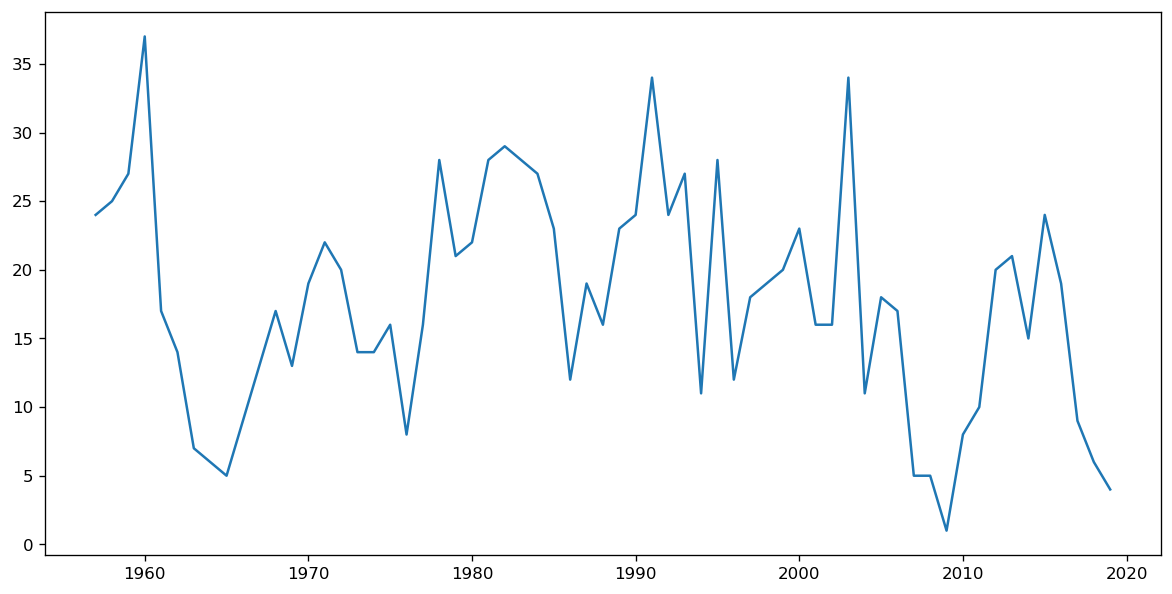

In [16]:
#Forecasting moderate storms

plt.plot(year,mod_storm)

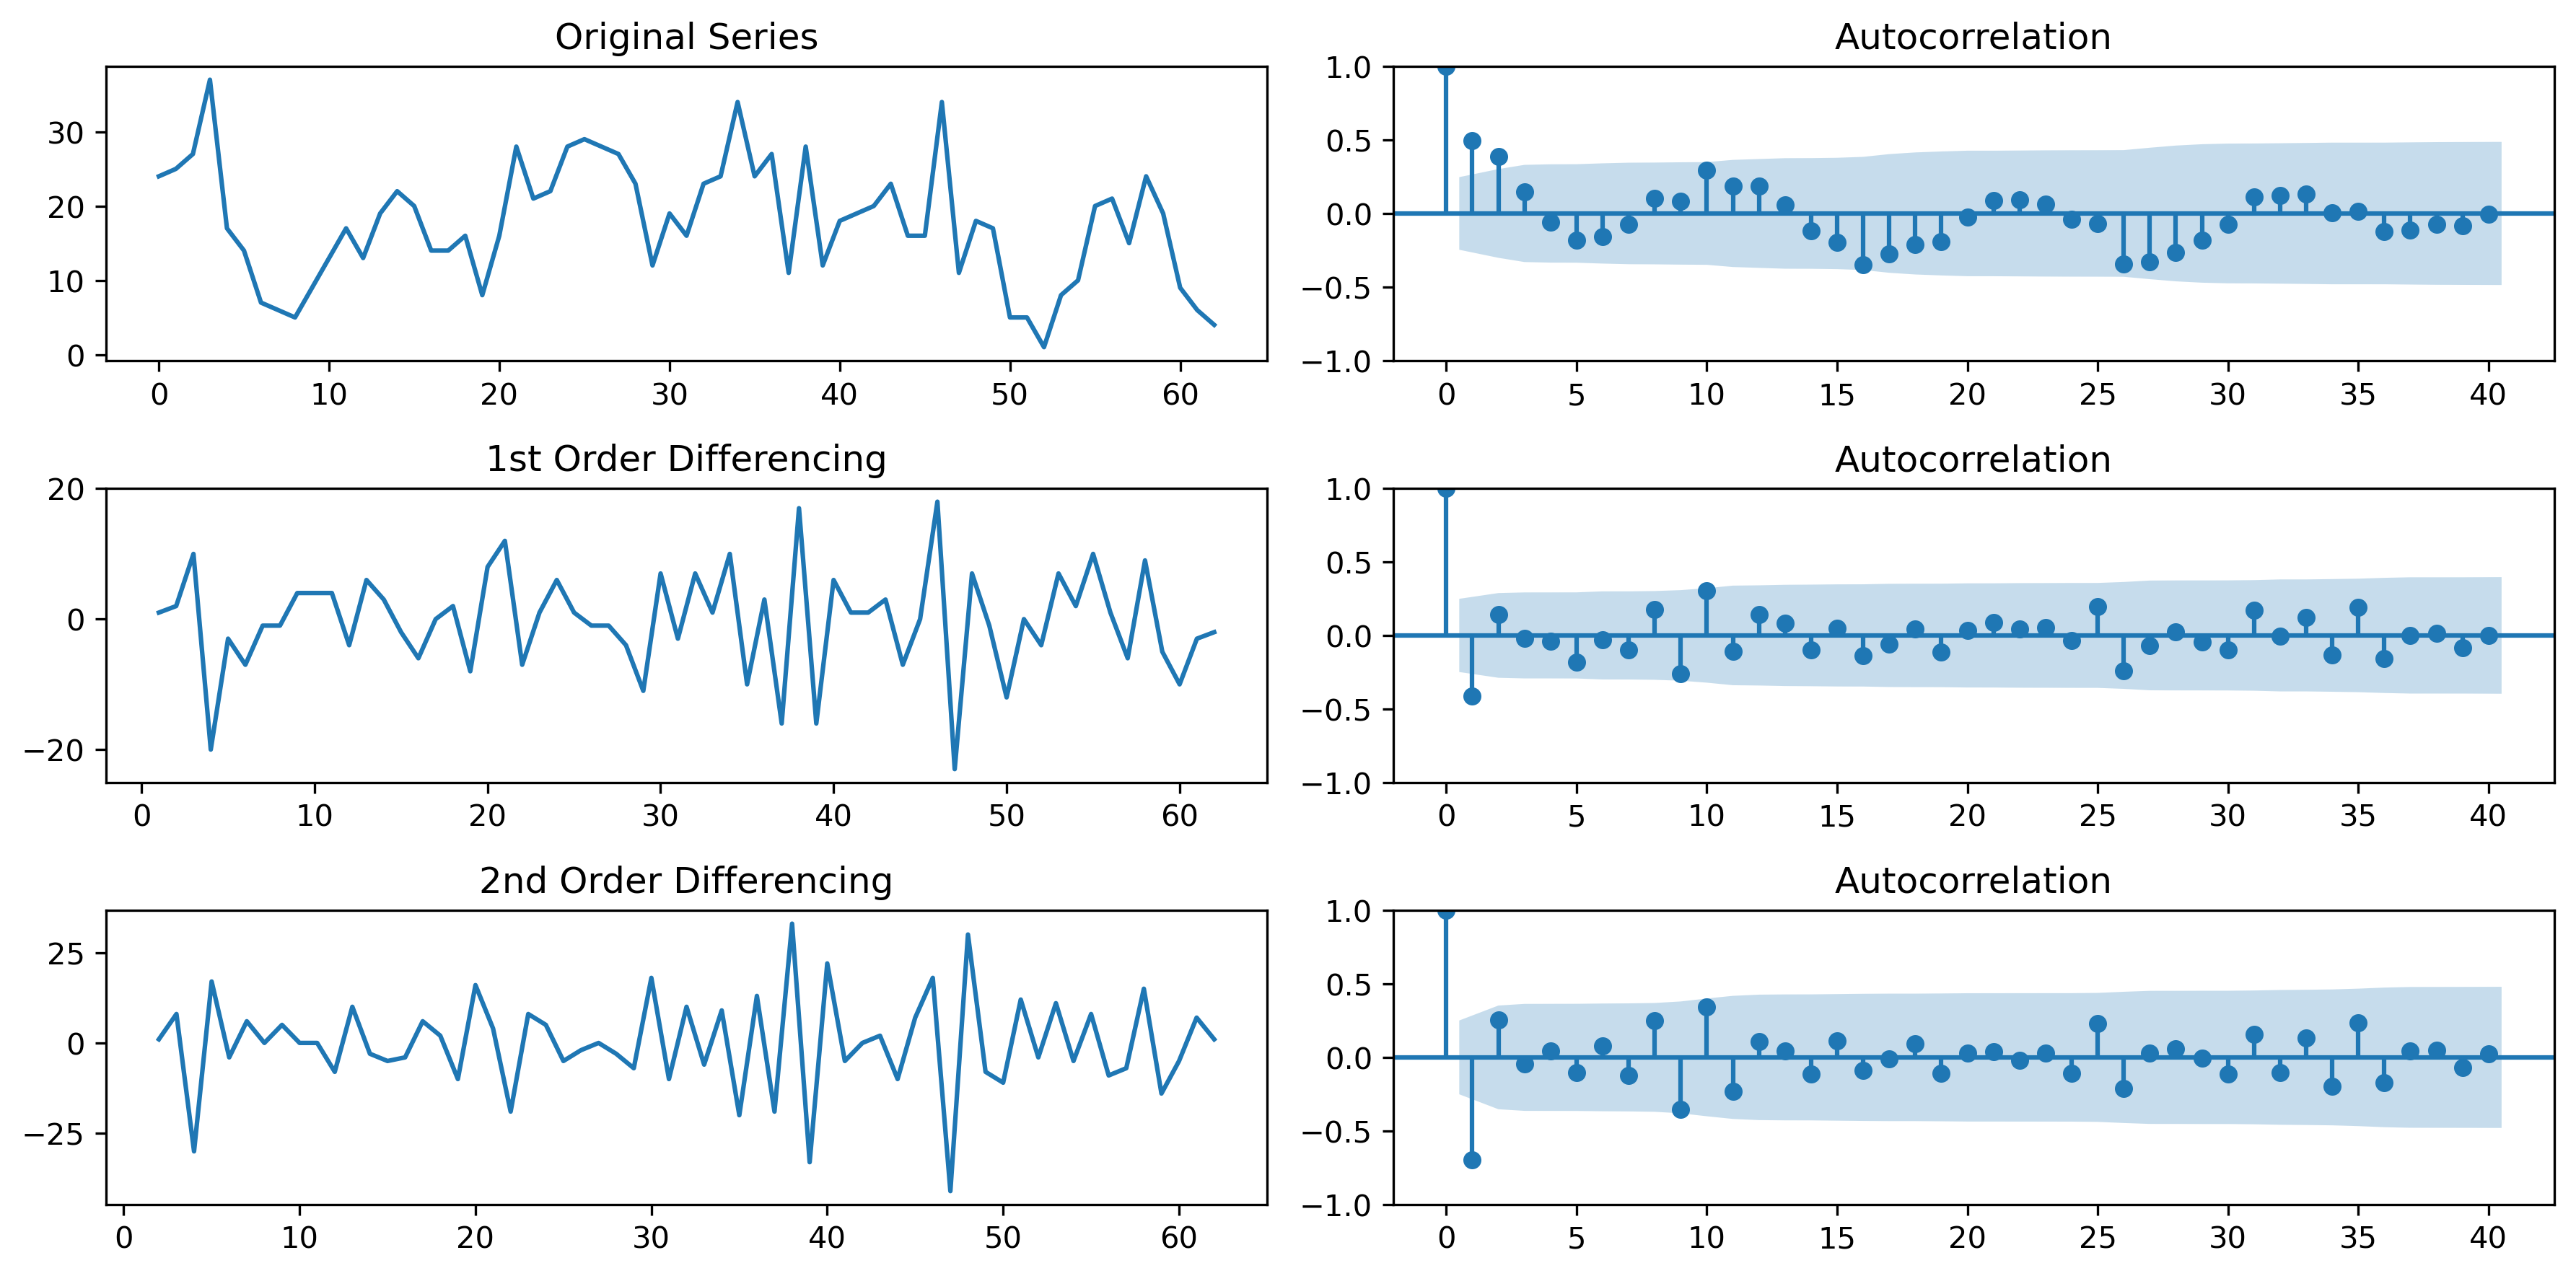

In [17]:
mod_storm_diff=mod_storm.diff()


# Original Series
fig, axes = plt.subplots(3, 2,dpi=300)
axes[0, 0].plot(mod_storm); axes[0, 0].set_title('Original Series')
plot_acf(mod_storm, ax=axes[0, 1],lags=40)

# 1st Differencing
axes[1, 0].plot(mod_storm.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(mod_storm.diff().dropna(), ax=axes[1, 1],lags=40)

# 2nd Differencing
axes[2, 0].plot(mod_storm.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(mod_storm.diff().diff().dropna(), ax=axes[2, 1],lags=40)
plt.tight_layout()
plt.show()

#As there are significa

In [18]:
from scipy.stats import kruskal

def seasonality_test(series):
        seasoanl = False
        idx = np.arange(len(series.index)) % 12
        H_statistic, p_value = kruskal(series, idx)
        if p_value <= 0.05:
            seasonal = True
        return seasonal

In [19]:
seasonality_test(all_storm)

True

In [20]:
seasonality_test(mod_storm)

True

In [21]:
sarima_grid_search(mod_storm,11)

The set of parameters with the minimum AIC is: SARIMA(0, 1, 1)x(0, 1, 1, 11) - AIC:263.50398386940964


In [22]:
model = SARIMAX(mod_storm, order=(0,1,1), seasonal_order=(0,1,1,11), enforce_stationarity=False, enforce_invertibility=False)
model_fit = model.fit()
print(model_fit.summary())
 

                                     SARIMAX Results                                      
Dep. Variable:                          mod-storm   No. Observations:                   63
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 11)   Log Likelihood                -128.752
Date:                            Mon, 19 Sep 2022   AIC                            263.504
Time:                                    00:31:22   BIC                            268.417
Sample:                                         0   HQIC                           265.252
                                             - 63                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7714      0.106     -7.295      0.000      -0.979      -0.564
ma.S.L11      -1.0000   5516.027   

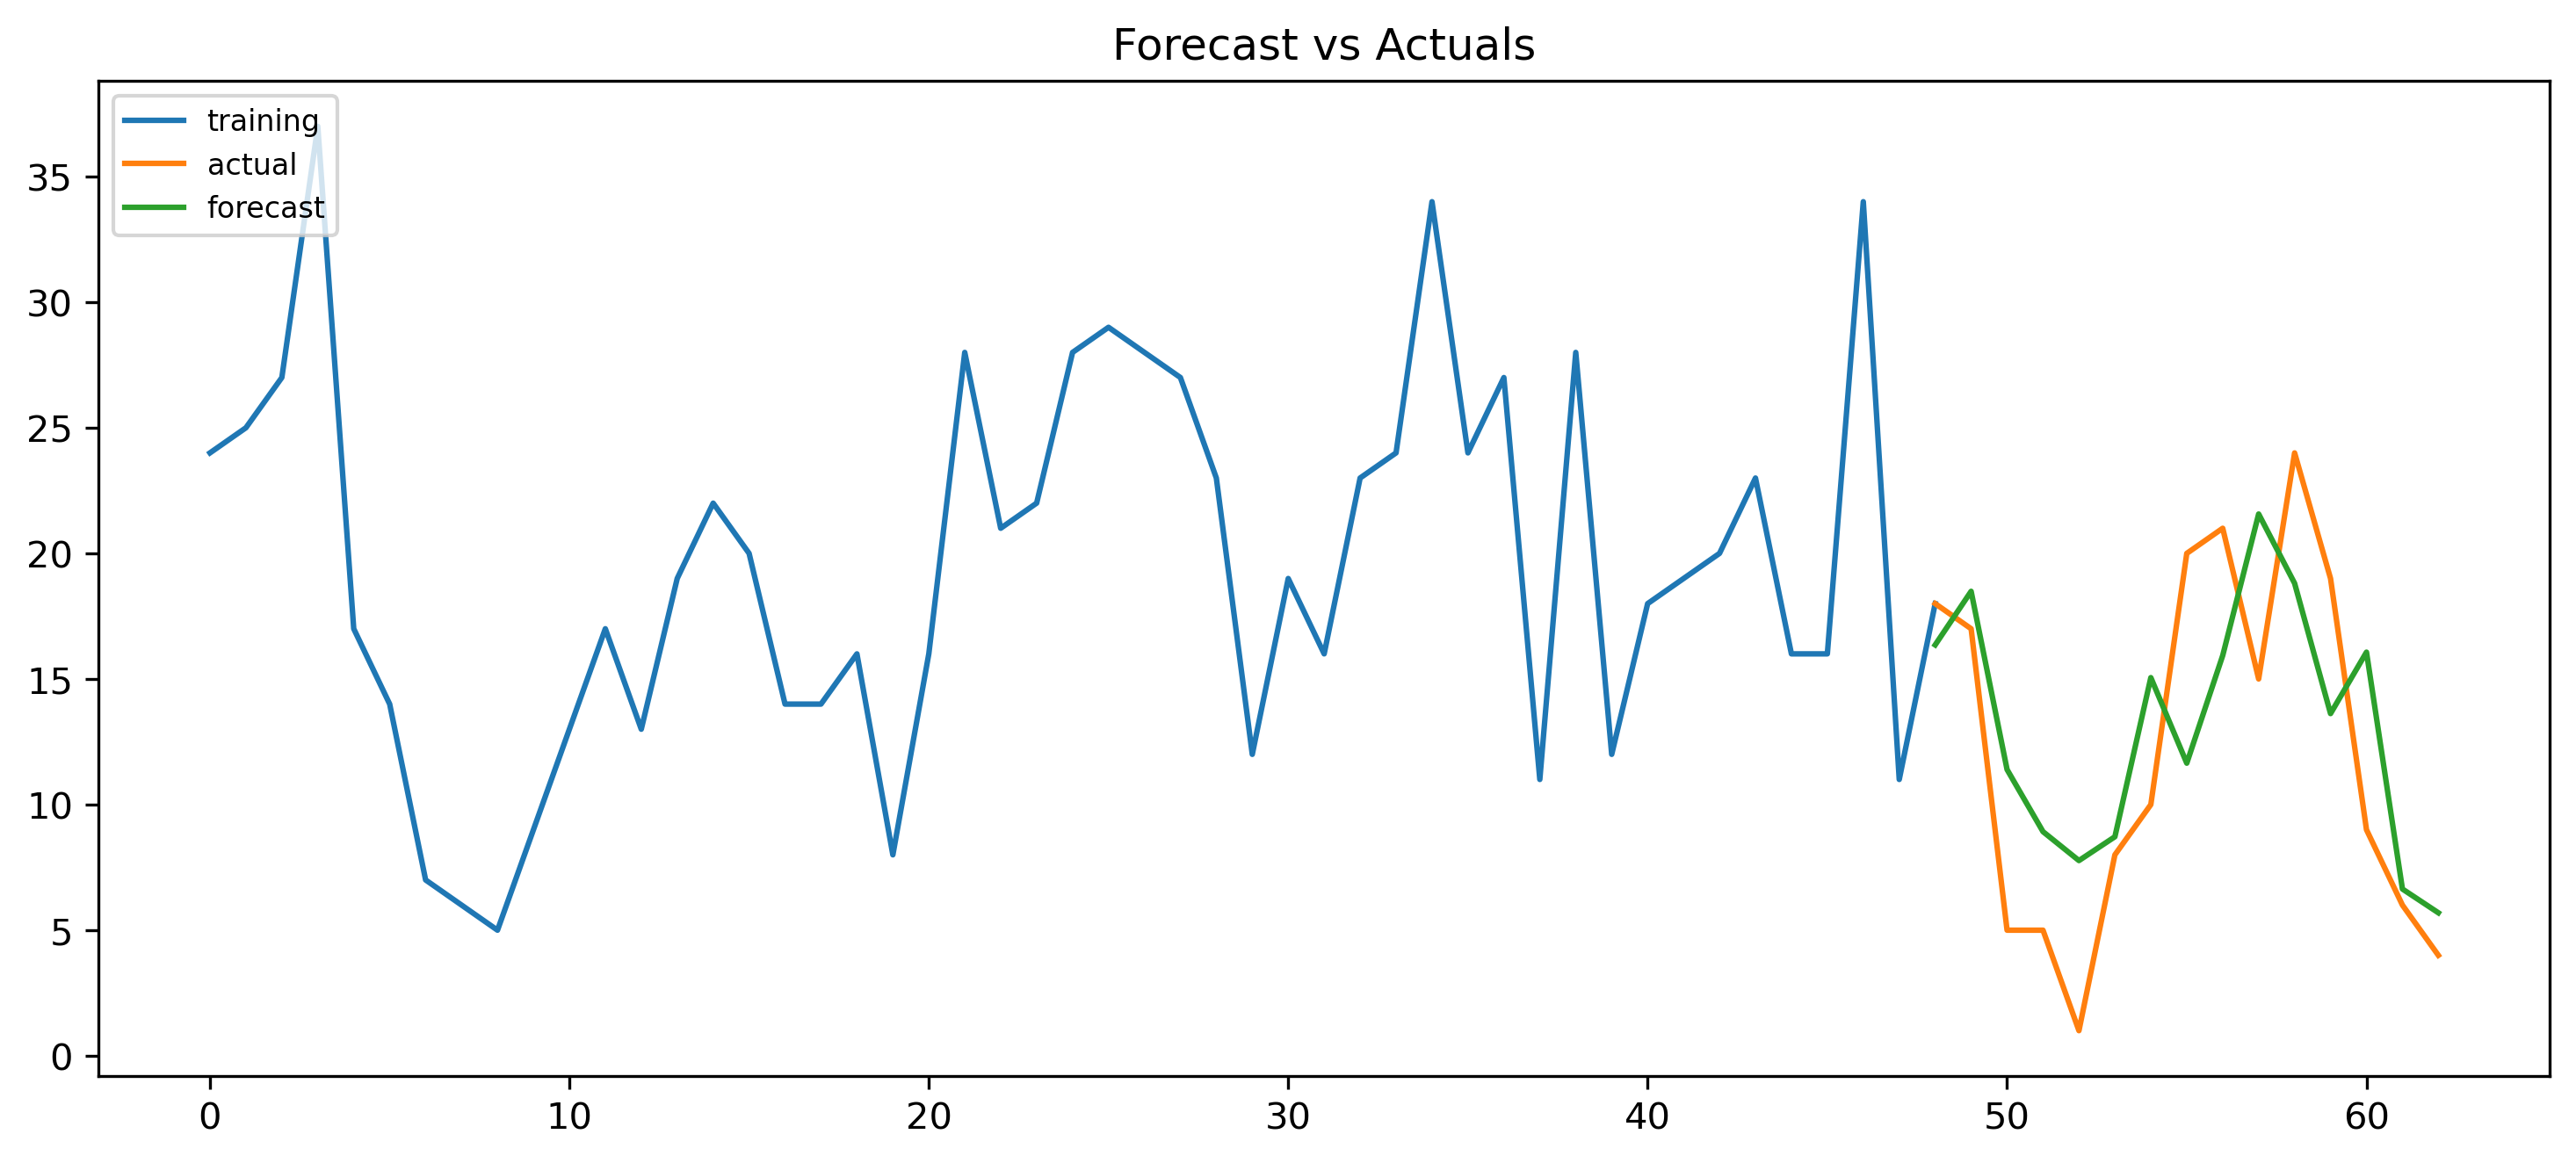

In [23]:
mod_storm_train=mod_storm[:49]
test=mod_storm[48:]
model = SARIMAX(mod_storm, order=(0,1,1), seasonal_order=(0,1,1,11), enforce_stationarity=False, enforce_invertibility=False)  
fitted = model.fit()  

# Forecast
fc = fitted.predict(start=48)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
# lower_series = pd.Series(fc[:, 0], index=test.index)
# upper_series = pd.Series(fc[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=300)
plt.plot(mod_storm_train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
# plt.fill_between(lower_series.index, lower_series, upper_series, 
#                  color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
# plt.xlim(200,330)
plt.show()


In [24]:
forecast_accuracy(fc,test)

C:\Users\Santhosh Pamula\AppData\Local\Temp\ipykernel_19664\3769355770.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mins = np.amin(np.hstack([forecast[:,None],
C:\Users\Santhosh Pamula\AppData\Local\Temp\ipykernel_19664\3769355770.py:11: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)
C:\Users\Santhosh Pamula\AppData\Local\Temp\ipykernel_19664\3769355770.py:12: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  maxs = np.amax(np.hstack([forecast[:,None],
C:\Users\Santhosh Pamula\AppData\Local\Temp\ipykernel_19664\3769355770.py:13: FutureWarning: Support

{'mape': 0.8346973039281151,
 'me': 0.979360558654371,
 'mae': 4.396711779398248,
 'mpe': 0.6681015138047647,
 'rmse': 5.03832170746022,
 'acf1': -0.05411977848807738,
 'corr': 0.7200907080957998,
 'minmax': 0.3172327808511902}

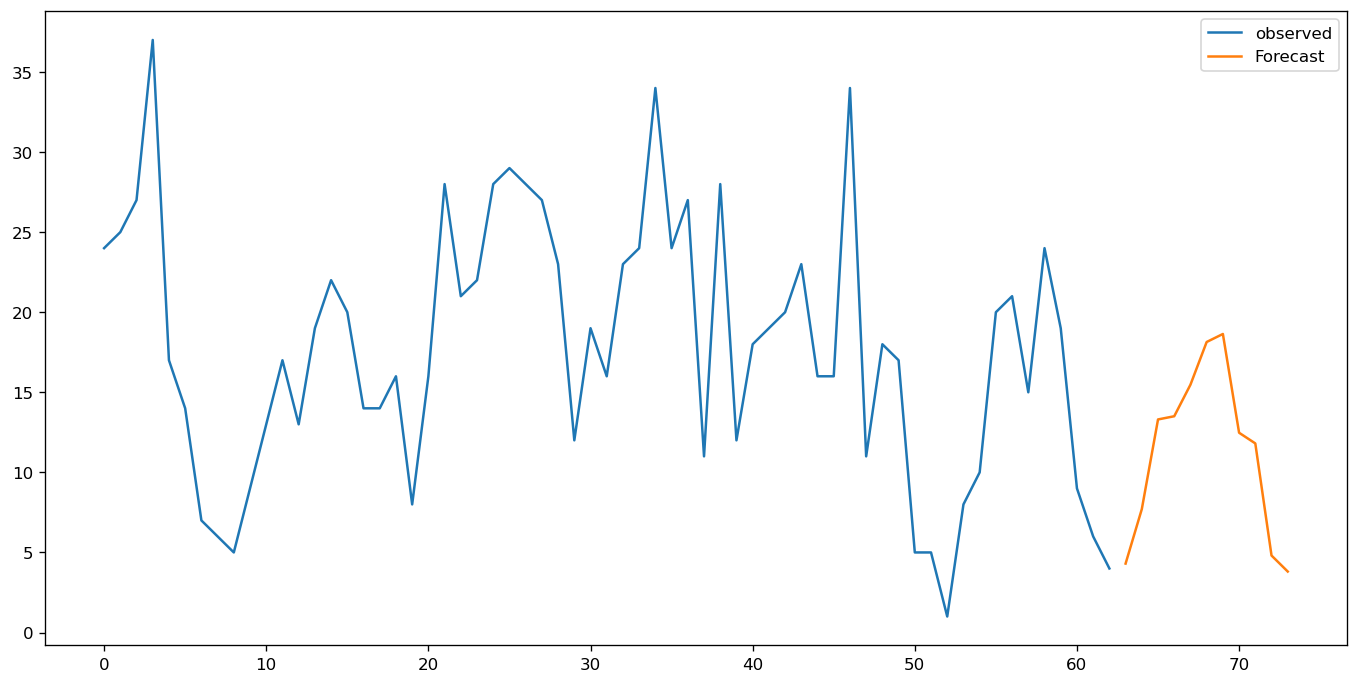

In [25]:
pred_uc=fitted.get_forecast(steps=11)
ax = mod_storm.plot(label='observed', figsize=(14, 7))
#     print(pred_uc.predicted_mean)
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
plt.legend()
plt.show()

In [26]:
#forecasted values

pred_uc.predicted_mean

63     4.304558
64     7.704551
65    13.304471
66    13.504620
67    15.474278
68    18.140930
69    18.640919
70    12.474283
71    11.807587
72     4.807619
73     3.807605
Name: predicted_mean, dtype: float64